In [18]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

In [19]:
# Parameters
image_size = (128, 128)
batch_size = 32
num_classes = 15
num_epochs = 5 
validation_split = 0.2

In [20]:
dataset_dir = r"D:\Ashraf\NCI\Semester 2\DMML2\CA2\Dataset\PlantVillage"
base_dir = r"D:\Ashraf\NCI\Semester 2\DMML2\CA2\Dataset\New"

In [25]:
# Data Preparation
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

validation_dataset = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 16504 images belonging to 15 classes.
Found 4134 images belonging to 15 classes.


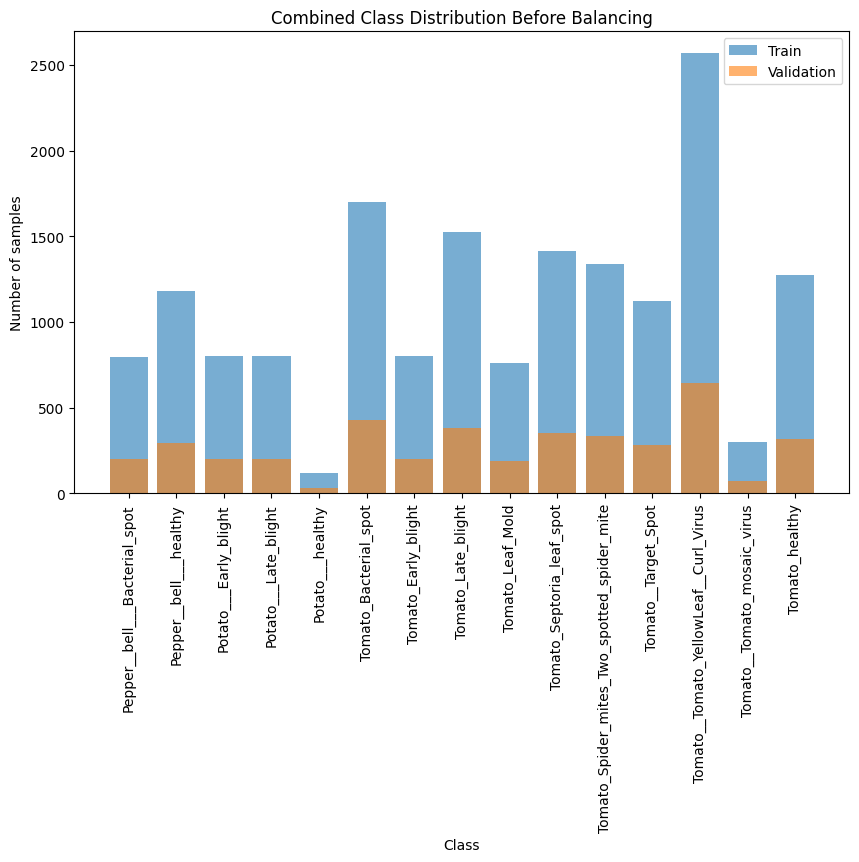

In [26]:
# Function to plot class distribution for both training and validation datasets
def plot_combined_class_distribution(train_dataset, validation_dataset, title):
    class_counts_train = pd.Series(train_dataset.classes).value_counts().sort_index()
    class_counts_val = pd.Series(validation_dataset.classes).value_counts().sort_index()
    class_labels = [k for k, v in train_dataset.class_indices.items()]
    
    plt.figure(figsize=(10, 6))
    plt.bar(class_labels, class_counts_train, alpha=0.6, label='Train')
    plt.bar(class_labels, class_counts_val, alpha=0.6, label='Validation')
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

# Plot class distribution before balancing
plot_combined_class_distribution(train_dataset, validation_dataset, 'Combined Class Distribution Before Balancing')

In [27]:
# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_dataset.classes),
    y=train_dataset.classes)

class_weights = dict(enumerate(class_weights))

In [28]:
# Build VGG19 Model
vgg_base = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in vgg_base.layers:
    layer.trainable = False
x_vgg = GlobalAveragePooling2D()(vgg_base.output)
x_vgg = Dense(1024, activation='relu')(x_vgg)
predictions_vgg = Dense(num_classes, activation='softmax')(x_vgg)
vgg_model = Model(inputs=vgg_base.input, outputs=predictions_vgg)

In [29]:
# Compile the Model
vgg_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
# Train the Model
vgg_history = vgg_model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // batch_size,
    epochs=num_epochs,
    validation_data=validation_dataset,
    validation_steps=validation_dataset.samples // batch_size,
    class_weight=class_weights)

Epoch 1/5


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


515/515 ━━━━━━━━━━━━━━━━━━━━ 1264s 2s/step - accuracy: 0.4117 - loss: 1.8152 - val_accuracy: 0.6269 - val_loss: 1.1185
Epoch 2/5
  1/515 ━━━━━━━━━━━━━━━━━━━━ 23:10 3s/step - accuracy: 0.7500 - loss: 0.7351

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


515/515 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7500 - loss: 0.7351 - val_accuracy: 1.0000 - val_loss: 0.3383
Epoch 3/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 1696s 3s/step - accuracy: 0.6458 - loss: 1.0514 - val_accuracy: 0.6710 - val_loss: 1.0335
Epoch 4/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 886us/step - accuracy: 0.5938 - loss: 1.0713 - val_accuracy: 0.6667 - val_loss: 1.1952
Epoch 5/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 1262s 2s/step - accuracy: 0.6880 - loss: 0.9021 - val_accuracy: 0.6703 - val_loss: 1.0024


In [31]:
# Save the Model
vgg_model.save('vgg19_plant_disease_model_2.h5')

In [32]:
# Evaluation of VGG Model
vgg_loss, vgg_accuracy = vgg_model.evaluate(validation_dataset)

print(f"VGG Validation accuracy: {vgg_accuracy*100:.2f}%")

130/130 ━━━━━━━━━━━━━━━━━━━━ 333s 3s/step - accuracy: 0.6662 - loss: 0.9959
VGG Validation accuracy: 66.67%


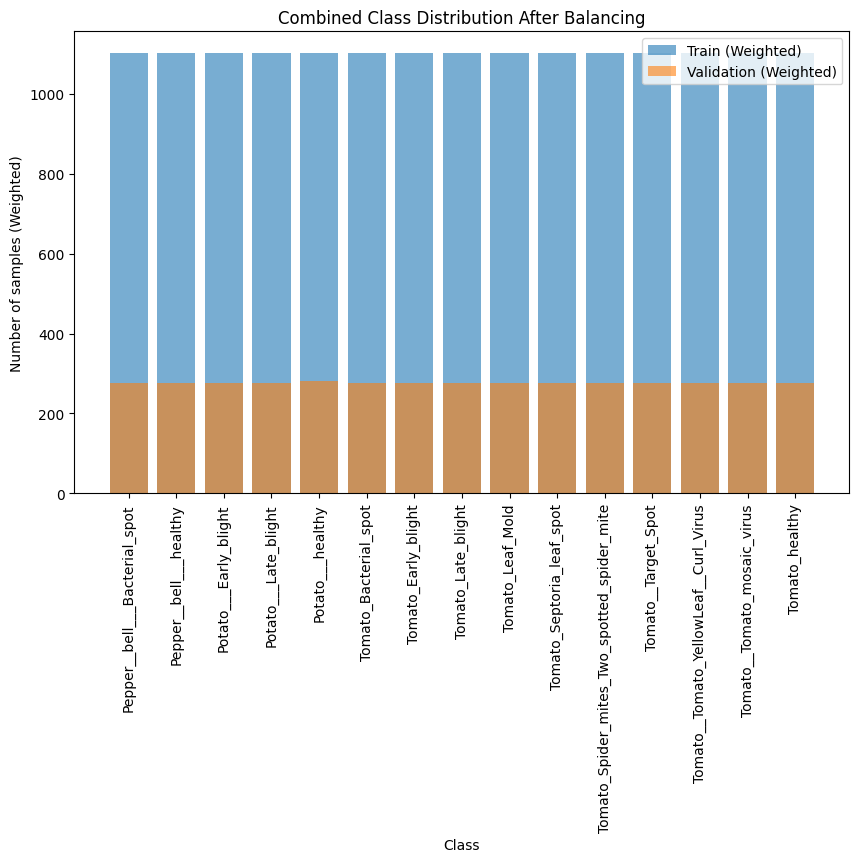

In [33]:
# Function to plot class distribution for both training and validation datasets after balancing
def plot_combined_class_distribution_balanced(train_dataset, validation_dataset, class_weights, title):
    class_counts_train = pd.Series(train_dataset.classes).value_counts().sort_index()
    class_counts_val = pd.Series(validation_dataset.classes).value_counts().sort_index()
    class_labels = [k for k, v in train_dataset.class_indices.items()]
    
    balanced_class_counts_train = class_counts_train * [class_weights[i] for i in range(len(class_weights))]
    balanced_class_counts_val = class_counts_val * [class_weights[i] for i in range(len(class_weights))]

    plt.figure(figsize=(10, 6))
    plt.bar(class_labels, balanced_class_counts_train, alpha=0.6, label='Train (Weighted)')
    plt.bar(class_labels, balanced_class_counts_val, alpha=0.6, label='Validation (Weighted)')
    plt.xlabel('Class')
    plt.ylabel('Number of samples (Weighted)')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

# Plot class distribution after balancing
plot_combined_class_distribution_balanced(train_dataset, validation_dataset, class_weights, 'Combined Class Distribution After Balancing')

In [36]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# Predict the classes for the validation dataset
validation_dataset.reset()
vgg_predictions = vgg_model.predict(validation_dataset)
vgg_predicted_classes = np.argmax(vgg_predictions, axis=1)
true_classes = validation_dataset.classes
class_labels = list(validation_dataset.class_indices.keys())

130/130 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step


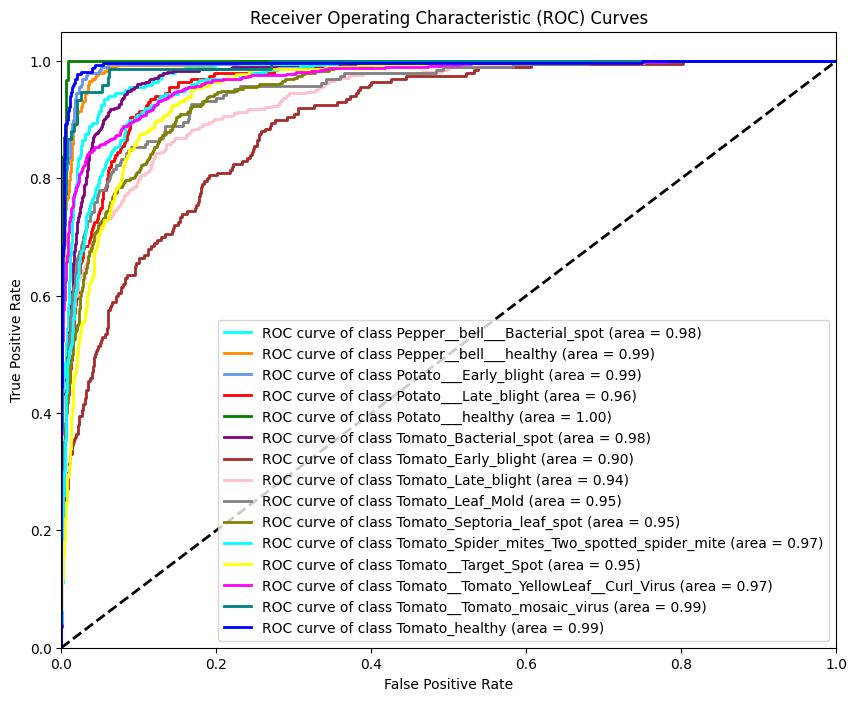

In [37]:
# Binarize the true classes and predictions for ROC curve computation
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the output
true_classes_binarized = label_binarize(true_classes, classes=range(num_classes))
vgg_predictions_binarized = label_binarize(vgg_predicted_classes, classes=range(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_classes_binarized[:, i], vgg_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'yellow', 'magenta', 'teal', 'blue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


# Plant Care

In [39]:
import pandas as pd

care_info_df = pd.read_csv(r"D:\Ashraf\NCI\Semester 2\DMML2\CA2\Dataset\care_info.csv")

care_info_df.head(10)

,Plant Name and Disease,Sunlight,Water,Water in liters,Cure
0,Pepper__bell___Bacterial_spot,6-8 hours of direct sunlight,Keep soil consistently moist but not waterlogged,1-1.5 liters per day,Remove infected leaves and apply copper-based ...
1,Pepper__bell___healthy,6-8 hours of direct sunlight,Water when the top 1 inch of soil is dry,1 liter per day,"No disease detected, maintain healthy growth p..."
2,Potato___Early_blight,Full sun,"Water deeply, allowing soil to dry between wat...",1-1.5 liters per day,Apply fungicides and remove affected leaves
3,Potato___Late_blight,Full sun,Keep soil evenly moist but avoid overwatering,1-1.5 liters per day,Use resistant varieties and apply appropriate ...
4,Potato___healthy,Full sun,Water when the top 2 inches of soil are dry,1-1.5 liters per day,"No disease detected, maintain healthy growth p..."
5,Tomato_Bacterial_spot,6-8 hours of direct sunlight,"Water at the base, avoiding wetting the foliage",1-1.5 liters per day,Remove infected leaves and apply copper-based ...
6,Tomato_Early_blight,6-8 hours of direct sunlight,"Water deeply, allowing soil to dry between wat...",1.5-2 liters per day,Apply fungicides and remove affected leaves
7,Tomato_Late_blight,6-8 hours of direct sunlight,Keep soil evenly moist but avoid overwatering,1.5-2 liters per day,Use resistant varieties and apply appropriate ...
8,Tomato_Leaf_Mold,6-8 hours of direct sunlight,"Water at the base, keeping foliage dry",1.5-2 liters per day,Improve air circulation and apply fungicides
9,Tomato_Septoria_leaf_spot,6-8 hours of direct sunlight,"Water at the base, avoiding wetting the foliage",1.5-2 liters per day,Remove infected leaves and apply fungicides


In [40]:
# Convert the DataFrame to a dictionary for easy lookup
care_info = care_info_df.set_index('Plant Name and Disease').T.to_dict()

# Function to get care recommendations based on predicted class
def get_care_recommendations(predicted_class):
    if predicted_class in care_info:
        return care_info[predicted_class]
    else:
        return {
            'Sunlight': 'Information not available',
            'Water': 'Information not available',
            'Water in liters': 'Information not available',
            'Cure': 'Information not available'
        }

In [41]:
# Predict and provide care recommendations for the first image in the validation set
class_labels = list(validation_dataset.class_indices.keys())
validation_dataset.reset()
vgg_predictions = vgg_model.predict(validation_dataset)
vgg_predicted_classes = np.argmax(vgg_predictions, axis=1)

# Get recommendations for the first predicted class
predicted_class = class_labels[vgg_predicted_classes[0]]
recommendations = get_care_recommendations(predicted_class)
print(f"Recommendations for {predicted_class}:")
print(f"Sunlight: {recommendations['Sunlight']}")
print(f"Water: {recommendations['Water']}")
print(f"Water in liters: {recommendations['Water in liters']}")
print(f"Cure: {recommendations['Cure']}")

130/130 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step
Recommendations for Pepper__bell___healthy:
Sunlight: 6-8 hours of direct sunlight
Water: Water when the top 1 inch of soil is dry
Water in liters: 1 liter per day
Cure: No disease detected, maintain healthy growth practices
